In [2]:
import numpy as np
import matplotlib.pyplot as plt

gamma = 1.0

In [3]:
Q = np.load("Q.npy")
C = np.load("C.npy")

In [4]:
def getGreedyPolicy(Q):
    return np.argmax(Q,axis=-1)

def innerMCControl(episode, Q, C, t_policy, getBPolicy):
    b_policy = getBPolicy(Q)
    G = 0.0
    W = 1.0
    converged = True
    step = len(episode)-1
    for state, action, reward in reversed(episode):
        G = gamma*G + reward
        C[state][action] += W
        q = Q[state][action]
        Q[state][action] += W/C[state][action] * (G-Q[state][action])
        converged = converged and abs(q - Q[state][action]) < CONVERGENCE_ERROR
        t_policy[state] = np.argmax(Q[state])
        if t_policy[state] != action: break
        W *= 1.0/b_policy[state][action]
        step -= 1
    
    print("\repisode length:{:7}; steps used:{:3}".format(len(episode),len(episode)-step), 
          end='', flush=True)
    return converged

In [5]:
def MCControl(episodes,C,getBPolicy,QShape):
    C = np.zeros(dtype=np.float, shape=episodes.QShape)
    t_policy = getGreedyPolicy(episodes.Q)
    for episode in episodes:
        innerMCControl(episode, episodes.Q, C, t_policy, lambda Q: episodes.policy)

In [5]:
MAX_VELOCITY = 4
MIN_VELOCITY = 0
TRACK_TAG = 1
RT_grid = [3,6,3,
           2,7,7,
           1,8,8,
           0,9,7,
           0,10,1,
           0,17,2,
           1,16,1,
           2,15,2,
           3,14,1]
START_TAG = 2
start_line = (0,3,1,9)
FINISH_TAG = 3
finish_line = (26,16,32,17)
track_data = np.array(RT_grid).reshape((-1,3))
reward = -1
CONVERGENCE_ERROR = 0.02

In [6]:
def rt_getStartPosition():
    return (0,np.random.randint(start_line[1], start_line[3]),0,0)

def getBPolicy(Q, epsilon):
    eps_policy = np.ones(dtype=np.float, shape=Q.shape) * epsilon/ACTIONS_NUM
    for state in np.ndindex(Q.shape[:-1]):
        action = np.argmax(Q[state])
        eps_policy[state][action] += 1.0-epsilon
    return eps_policy

def getBPolicyLog(Q, epsilon, step):
    e = min(1.0, epsilon/np.log(max(2,step/100)))
    eps_policy = np.ones(dtype=np.float, shape=Q.shape) * e/ACTIONS_NUM
    for state in np.ndindex(Q.shape[:-1]):
        action = np.argmax(Q[state])
        eps_policy[state][action] += 1.0-e
    return eps_policy


In [7]:
ACCELERATION =  [[1,-1],  [1,0],  [1,1],
                 [0,-1],  [0,0],  [0,1],
                [-1,-1], [-1,0], [-1,1]]
ACTIONS_NUM = len(ACCELERATION)

def rt_transition(track, state, action, getStartPosition=rt_getStartPosition):
    #next_velocity = np.vectorize(lambda x: min(x,MAX_VELOCITY))(state[1]+action)
    accel = ACCELERATION[action]
    next_velocity = np.clip([state[2]+accel[0],state[3]+accel[1]], 
                            MIN_VELOCITY, MAX_VELOCITY)
    if (next_velocity == [0,0]).all():
        next_velocity = [state[2],state[3]]
    position = [state[0],state[1]]
    next_position = position + next_velocity
    disp = next_velocity
    #intersection_row = (disp[0]/disp[1]) * (track.shape[1]-position[1]) + position[0]
    is_finished = next_position[1] >= track.shape[1] and \
        26.0 <= (disp[0]/disp[1]) * (track.shape[1]-position[1]) + position[0] < 32.0
    
    if is_finished: return (True,getStartPosition())
    
    next_position = tuple(next_position)
    if next_position in np.ndindex(track.shape) and \
        track[next_position] > 0:
        next_state = next_position + tuple(next_velocity)
    else:
        next_state = getStartPosition()
        
    return (False,next_state)


In [8]:
### Building race track ###
# Determine extents of race track grid.
track = np.zeros(shape=(np.sum(track_data[:,-1]), 
                        max(np.sum(track_data[:,:-1], axis=1))),
                dtype = np.uint8)
print(track.shape)
row=0
for start,length,repeat in track_data:
    for i in range(repeat):
        track[row, start:start+length] = TRACK_TAG
        row += 1
track[start_line[0]:start_line[2],start_line[1]:start_line[3]] = START_TAG
track[finish_line[0]:finish_line[2],finish_line[1]:finish_line[3]] = FINISH_TAG

(32, 17)


disp[1]/disp[0] == (track.shape[1]-position[1])/(track_row-position[0])
track_row = (disp[0]/disp[1]) * (track.shape[1]-position[1]) + position[0]

In [9]:
def getAction(policy, state):
    return (np.nonzero(np.random.multinomial(1, policy[state]))[0])[0]

def rt_generateEpisode(b_policy, getAction):
    state = rt_getStartPosition()
    episode = []
    while True:
        action = getAction(b_policy, state)
        episode.append((state, action, reward))
        is_finished, next_state = rt_transition(track, state, action)
        if is_finished: break
        state = next_state
        
    return episode

In [10]:
class Episodes:
    def __init__(self, N, Q, track, getBPolicy):
        self.samples_num = N
        self.state_shape = Q.shape[:-1]
        self.Q = Q
        self.getBPolicy = getBPolicy
    
    def __iter__(self):
        self.N = self.samples_num
        return self
    
    def __next__(self):
        if self.N == 0: raise StopIteration
        self.N -= 1
        self.policy = self.getBPolicy(self.Q, self.samples_num-self.N)
        return rt_generateEpisode(self.policy, getAction)

In [11]:
def MC_run(N, Q, C):
    episodes = Episodes(N, Q, track, lambda q,s: getBPolicy(q,10000.0/(20000.0+s)))
                        #lambda q,s: rt_getBPolicy(q,0.5)) #lambda q,s: getBPolicyLog(q,0.7,s))
    t_policy = getGreedyPolicy(episodes.Q)
    conv_count = 0
    for episode in episodes:
        if innerMCControl(episode, episodes.Q, C, t_policy, lambda Q: episodes.policy):
            conv_count += 1
        else: 
            conv_count = 0
        if conv_count >= 500:
            print("\nConvergence reached.")
            break
            
    print("\nEpisodes generated: {}".format(episodes.samples_num - episodes.N))

In [103]:
QShape = track.shape + (MAX_VELOCITY+1, MAX_VELOCITY+1, ACTIONS_NUM)
Q = (np.random.random(QShape)-0.5)*0.1 - 30.0
C = np.zeros(dtype=np.float, shape=Q.shape)
MC_run(40000, Q, C)

episode length:     11; steps used: 12
Convergence reached.

Episodes generated: 14511


In [20]:
MC_run(50000, Q, C)

episode length:     10; steps used:  3
Episodes generated: 50000


In [15]:
def buildEpisode(startPosition, policy):
    state = startPosition
    episode = []
    while True:
        action = policy[state]
        episode.append((state, action, reward))
        is_finished, next_state = rt_transition(track, state, action, lambda:startPosition)
        if is_finished or next_state==startPosition: break
        state = next_state
        
    return episode

def buildTrack(policy):
    return

In [18]:
p = getGreedyPolicy(Q)
episode = buildEpisode((0,3,0,0),p)
last = episode[-1]
episode.append((tuple(np.array(last[0][:2])+np.array(last[0][2:])+ACCELERATION[last[1]]) +
               (0,0),0,len(episode)))

trace = np.array([list(s[:2]) for s,a,r in episode])
episode

[((0, 3, 0, 0), 5, -1),
 ((0, 4, 0, 1), 0, -1),
 ((1, 4, 1, 0), 2, -1),
 ((3, 5, 2, 1), 0, -1),
 ((6, 5, 3, 0), 1, -1),
 ((10, 5, 4, 0), 0, -1),
 ((14, 5, 4, 0), 2, -1),
 ((18, 6, 4, 1), 5, -1),
 ((22, 8, 4, 2), 2, -1),
 ((26, 11, 4, 3), 2, -1),
 ((30, 15, 4, 4), 7, -1),
 ((33, 19, 0, 0), 0, 11)]

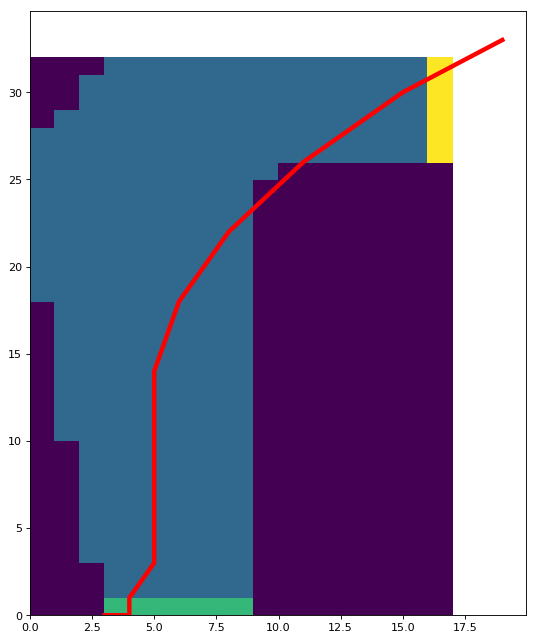

In [21]:
f = plt.figure(num=None, figsize=(8,10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(track, figure=f)
plt.plot(trace[:,1], trace[:,0], figure=f, linewidth=4.0, color='red')

In [84]:
QShape = track.shape + (MAX_VELOCITY+1, MAX_VELOCITY+1, ACTIONS_NUM)
Q = (np.random.random(QShape)-0.5)*0.1 - 30.0
episodes = Episodes(200, Q, track, lambda q,s: getBPolicyLog(q,0.7,s))
C = np.zeros(dtype=np.float, shape=episodes.Q.shape)
t_policy = getGreedyPolicy(episodes.Q)
conv_count = 0
for episode in episodes:
    if innerMCControl(episode, episodes.Q, C, t_policy, lambda Q: episodes.policy):
        conv_count += 1
    else: 
        conv_count = 0
    if conv_count > 100:
        print("Convergence reached.")
print("\nEpisodes generated: {}".format(episodes.samples_num - episodes.N))

episode length:  10141; steps used:  2
Episodes generated: 200


In [46]:
episodes = Episodes(2000, episodes.Q, track, lambda Q,s: rt_getBPolicy(Q,s,0.5))
for episode in episodes:
    innerMCControl(episode, episodes.Q, C, t_policy, lambda Q: episodes.policy)

episode length:     18; steps used: 10

In [7]:
def rt_getTargetPolicyAction(Q, state):
    return np.argmax(Q[state])

In [34]:
aa = np.array(list(zip(*np.nonzero(C))))
len(aa)

7267

In [25]:
pos = (0,8)
ind = np.unravel_index(np.argmax(Q[pos]),Q[pos].shape)
ind, Q[pos][ind]
#aa[-50:]

((0, 1, 0), -11.064158314306082)

In [154]:
np.save("Q",Q)
np.save("C",C)

In [ ]:
epsilon = 0.5
getBPolicy = lambda Q: rt_getBPolicy(Q,epsilon)
MCControl()

In [26]:
f,ns = rt_transition(track,state,action)
print(f,ns)
[(ACCELERATION[a],rt_transition(track,ns,a)) for a in range(9)]

False (31, 5, 1, 1)


[([1, -1], (False, (0, 6, 0, 0))),
 ([1, 0], (False, (0, 6, 0, 0))),
 ([1, 1], (False, (0, 6, 0, 0))),
 ([0, -1], (False, (0, 6, 0, 0))),
 ([0, 0], (False, (0, 6, 0, 0))),
 ([0, 1], (False, (0, 6, 0, 0))),
 ([-1, -1], (False, (31, 5, 0, 0))),
 ([-1, 0], (False, (31, 6, 0, 1))),
 ([-1, 1], (False, (31, 7, 0, 2)))]

In [17]:
0.5/np.log([2,3,10,100,1000])

array([0.72134752, 0.45511961, 0.21714724, 0.10857362, 0.07238241])

In [37]:
q = Q[1,8,1,0]
a = np.argmax(q)
q[a], ACCELERATION[a], C[1,8,1,0]


(-10.0,
 [1, -1],
 array([3826.69116941,  562.27887574,   61.33052762, 1853.56060307,
        3882.9613061 ,  260.64164729,   78.8653131 ,  424.20584327,
         177.71391095]))